In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
!ls

/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
data  LICENSE  README.md	 runs	  train.ipynb
lib   model    requirements.txt  scripts  train.py


In [3]:
# !pip install -r requirements.txt

In [4]:
# Unzip the datasets
!unzip data/metr-la.h5.zip -d data/
!unzip data/pems-bay.h5.zip -d data/

# Create data directories
!mkdir -p data/{METR-LA,PEMS-BAY}


Archive:  data/metr-la.h5.zip
replace data/metr-la.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  data/pems-bay.h5.zip
replace data/pems-bay.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## process data

how the spatiotemporal data is processed and formatted:

produce tensor x and y, each of dimension (#timesteps x #window_size x #nodes x 2). 2 is for value and time_offset. e.g. (34249, 12, 207, 2) 

x and y are shifted version (x is T-window_size to T while y is T+1 to T+window_size). Task is designed this way as model is supposed to predict y while looking at x



In [5]:
# METR-LA
!python -m scripts.generate_training_data --output_dir=data/METR-LA --traffic_df_filename=data/metr-la.h5


Generating training data
tcmalloc: large alloc 1361199104 bytes == 0x5559d79ec000 @  0x7f847b7131e7 0x7f847925346e 0x7f84792a3c7b 0x7f84792a3d18 0x7f847934b010 0x7f847934b73c 0x7f847934b85d 0x55591eb9a2b8 0x7f8479290ef7 0x55591eb97f97 0x55591eb97da0 0x55591ec0bbb3 0x55591ec06c35 0x55591eb9973a 0x55591ec0893b 0x55591ec07235 0x55591ead8e2c 0x7f8479290ef7 0x55591eb97f97 0x55591eb97da0 0x55591ec0bbb3 0x55591ec06c35 0x55591eb9973a 0x55591ec0893b 0x55591ec06c35 0x55591eb9973a 0x55591ec0893b 0x55591eb9965a 0x55591ec07b0e 0x55591eb9965a 0x55591ec07b0e
tcmalloc: large alloc 1361199104 bytes == 0x555a294cc000 @  0x7f847b7131e7 0x7f847925346e 0x7f84792a3c7b 0x7f84792a3d18 0x7f847934b010 0x7f847934b73c 0x7f847934b85d 0x55591eb9a2b8 0x7f8479290ef7 0x55591eb97f97 0x55591eb97da0 0x55591ec0bbb3 0x55591ec06c35 0x55591eb9973a 0x55591ec0893b 0x55591ec07235 0x55591ead8e2c 0x7f8479290ef7 0x55591eb97f97 0x55591eb97da0 0x55591ec0bbb3 0x55591ec06c35 0x55591eb9973a 0x55591ec0893b 0x55591ec06c35 0x55591eb9973a 

In [80]:
from scripts import generate_training_data

df.shape (34272, 207)


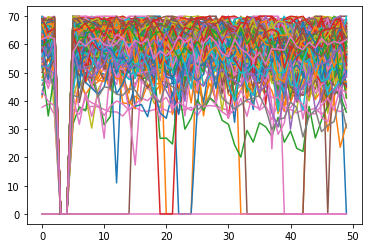

x.shape, y.shape (34249, 12, 207, 2) (34249, 12, 207, 2)
num_samples, num_test, num_train, num_val 34249 6850 23974 3425


In [83]:
# scripts.generate_training_data

import argparse
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

class DummyArgs():
  def __init__(self, output_dir, traffic_df_filename):
    self.output_dir = output_dir
    self.traffic_df_filename = traffic_df_filename

args = DummyArgs(output_dir="data/METR-LA", traffic_df_filename="data/metr-la.h5")

# generate_train_val_test(args)
df = pd.read_hdf(args.traffic_df_filename)

# 34272 time ticks and 207 stations
print("df.shape", df.shape)
# 50 time ticks
plt.plot(df.iloc[:50].values)
plt.show()

# get offsets
x, y = generate_training_data.generate_graph_seq2seq_io_data(
        df,
        x_offsets=x_offsets,
        y_offsets=y_offsets,
        add_time_in_day=True,
        add_day_in_week=False,
    )
print("x.shape, y.shape", x.shape, y.shape)

num_samples = x.shape[0]
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

print("num_samples, num_test, num_train, num_val", num_samples, num_test, num_train, num_val)

In [57]:
# indexes are datetime
df.index.values

array(['2012-03-01T00:00:00.000000000', '2012-03-01T00:05:00.000000000',
       '2012-03-01T00:10:00.000000000', ...,
       '2012-06-27T23:45:00.000000000', '2012-06-27T23:50:00.000000000',
       '2012-06-27T23:55:00.000000000'], dtype='datetime64[ns]')

In [84]:
# train
x_train, y_train = x[:num_train], y[:num_train]
# val
x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)
# test
x_test, y_test = x[-num_test:], y[-num_test:]

print("x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape", x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

# save x and y to numpy files

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape (23974, 12, 207, 2) (23974, 12, 207, 2) (3425, 12, 207, 2) (3425, 12, 207, 2) (6850, 12, 207, 2) (6850, 12, 207, 2)


In [59]:
# # def generate_graph_seq2seq_io_data(
# #         df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
# # ):
# df, x_offsets, y_offsets, add_time_in_day, add_day_in_week, scaler = df, x_offsets, y_offsets, True, False, None

# # num_samples = time ticks, num_nodes = total locations
# num_samples, num_nodes = df.shape
# data = np.expand_dims(df.values, axis=-1)
# data_list = [data]

# if add_time_in_day:
#     # calculate how many days since first value has it been
#     time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
#     # assign day offset to each node
#     time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
#     data_list.append(time_in_day)
# if add_day_in_week:
#     day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
#     day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
#     data_list.append(day_in_week)

# data = np.concatenate(data_list, axis=-1)
# # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
# x, y = [], []
# # t is the index of the last observation.
# min_t = abs(min(x_offsets))
# max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
# for t in range(min_t, max_t):
#     # for input data x (T-11 to T), predict output data y (T+1 to T+12)
#     x_t = data[t + x_offsets, ...]
#     y_t = data[t + y_offsets, ...]
#     # each element is 12 window size x 207 nodes x 2 values (value and time-offset)
#     x.append(x_t)
#     y.append(y_t)
# x = np.stack(x, axis=0)
# y = np.stack(y, axis=0)

# x, y

((34249, 12, 207, 2), (34249, 12, 207, 2))

In [78]:
# # show that x move offset forward by 12 window size is equal to y
# assert (x[12] - y[0]).sum() == 0

0.0

## train model

In [4]:
# Use METR-LA dataset
!python train.py --config_filename=data/model/para_la.yaml --temperature=0.5

2021-09-02 11:13:26,717 - INFO - Log directory: data/model/GTS_DR_3_h_12_64_lr_0.005_bs_64_0902111326/
2021-09-02 11:13:54,026 - INFO - Model created
2021-09-02 11:13:54,028 - INFO - Start training ...
2021-09-02 11:13:54,028 - INFO - num_batches:375
Num of epoch: 0
2021-09-02 11:13:54,605 - INFO - Total trainable parameters 38478291
2021-09-02 11:19:17,049 - INFO - epoch complete
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
2021-09-02 11:19:17,053 - INFO - evaluating now!
2021-09-02 11:19

In [5]:
# python train.py --config_filename=data/model/para_la.yaml --temperature=0.5

class DummyTrainArgs():
  def __init__(self, config_filename, use_cpu_only, temperature):
    self.config_filename = config_filename
    self.use_cpu_only = use_cpu_only
    self.temperature = temperature

args = DummyTrainArgs(config_filename="data/model/para_la.yaml", use_cpu_only=False, temperature=0.5)

import argparse
import yaml
from model.pytorch.supervisor import GTSSupervisor
from lib.utils import load_graph_data

with open(args.config_filename) as f:
    supervisor_config = yaml.load(f)
    save_adj_name = args.config_filename[11:-5]
    supervisor = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    # supervisor.train()


2021-09-02 12:32:00,804 - INFO - Log directory: data/model/GTS_DR_3_h_12_64_lr_0.005_bs_64_0902123200/
2021-09-02 12:32:18,210 - INFO - Model created


In [18]:
# supervisor.py

# adj_mx = initial adjacency matrix obtained from kneighbors_graph (cosine similarity of the whole time series length)
# adj_mx is directed adjacency matrix hence it's not symmetric
# if prior graph is not given, we use adj_mx as regularization loss

# num_nodes = 207
# horizon = 12
# seq_len = 12
# input_dim = 2, output_dim = 1

supervisor.adj_mx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')

In [22]:
# supervisor._train
# def _train(self, base_lr,
#  steps, patience=200, epochs=100, lr_decay_ratio=0.1, log_every=1, save_model=0,
#  test_every_n_epochs=10, epsilon=1e-8, **kwargs):



In [26]:
supervisor.GTS_model

GTSModel(
  (encoder_model): EncoderModel(
    (dcgru_layers): ModuleList(
      (0): DCGRUCell()
    )
  )
  (decoder_model): DecoderModel(
    (projection_layer): Linear(in_features=64, out_features=1, bias=True)
    (dcgru_layers): ModuleList(
      (0): DCGRUCell()
    )
  )
  (conv1): Conv1d(1, 8, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(10,), stride=(1,))
  (hidden_drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=383552, out_features=100, bias=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=200, out_features=100, bias=True)
  (fc_cat): Linear(in_features=100, out_features=2, bias=True)
)

In [32]:
supervisor._data["x_train"].shape

(23974, 12, 207, 2)

In [45]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label = "with_regularization"
temp = supervisor.temperature
gumbel_soft = True
batches_seen = 0

train_iterator = supervisor._data["train_loader"].get_iterator()
for batch_idx, (x, y) in enumerate(train_iterator):
  x, y = supervisor._prepare_data(x, y)
  output, mid_output = supervisor.GTS_model(label, x, supervisor._train_feas, temp, gumbel_soft, y, batches_seen)

  # time series loss
  loss_1 = supervisor._compute_loss(y, output)

  # adjacency matrix loss
  pred = mid_output.view(mid_output.shape[0] * mid_output.shape[1])
  true_label = supervisor.adj_mx.view(mid_output.shape[0] * mid_output.shape[1]).to(device)
  compute_loss = torch.nn.BCELoss()
  loss_g = compute_loss(pred, true_label)

  # combined loss
  loss = loss_1 + loss_g


  break

2021-09-02 13:09:59,384 - INFO - Total trainable parameters 38478291


In [47]:
loss, loss_1, loss_g

(tensor(11.9575, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(11.3955, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))

In [40]:
x.shape, output.shape, mid_output.shape, y.shape

(torch.Size([12, 64, 414]),
 torch.Size([12, 64, 207]),
 torch.Size([207, 207]),
 torch.Size([12, 64, 207]))

1. how was train_loader created from x_train? Why (12, 64, 414)?
2. how is GRU designed? What is mid_output? Seems like adjacency matrix. Mid_output is basically $z^i$
3. what is supervisor._train_feas? Why was it obtained from df[:num_train] (supervisor.py) isn't this look-ahead bias? This is used for node features

In [53]:
from torch.nn import functional as F

# def forward(self, label, inputs, node_feas, temp, gumbel_soft, labels=None, batches_seen=None):

label, inputs, node_feas, temp, gumbel_soft, labels, batches_seen = label, x, supervisor._train_feas, temp, gumbel_soft, y, batches_seen

# Get Adjacency Matrix from node features
# z^i=mid_output = FC(vec(conv(x^i=node_feas)))
x = node_feas.transpose(1, 0).view(supervisor.GTS_model.num_nodes, 1, -1)
x = supervisor.GTS_model.conv1(x)
x = F.relu(x)
x = supervisor.GTS_model.bn1(x)
# x = self.hidden_drop(x)
x = supervisor.GTS_model.conv2(x)
x = F.relu(x)
x = supervisor.GTS_model.bn2(x)
x = x.view(supervisor.GTS_model.num_nodes, -1)
x = supervisor.GTS_model.fc(x)
x = F.relu(x)
x = supervisor.GTS_model.bn3(x)
receivers = torch.matmul(supervisor.GTS_model.rel_rec, x)
senders = torch.matmul(supervisor.GTS_model.rel_send, x)
x = torch.cat([senders, receivers], dim=1)
x = torch.relu(supervisor.GTS_model.fc_out(x))
x = supervisor.GTS_model.fc_cat(x)
mid_output = x.softmax(-1)[:, 0].clone().reshape(supervisor.GTS_model.num_nodes, -1)

# sample adjacency matrix

# Get GNN-RNN output from adjacency matrix
# feeds into encoder
encoder_hidden_state = supervisor.GTS_model.encoder(inputs, adj)

# feeds into decoder

x.shape, mid_output.shape

(torch.Size([42849, 2]), torch.Size([207, 207]))

In [48]:
supervisor.use_curriculum_learning

True

In [35]:
# what is this
supervisor._train_feas.shape

torch.Size([23990, 207])

## RFP

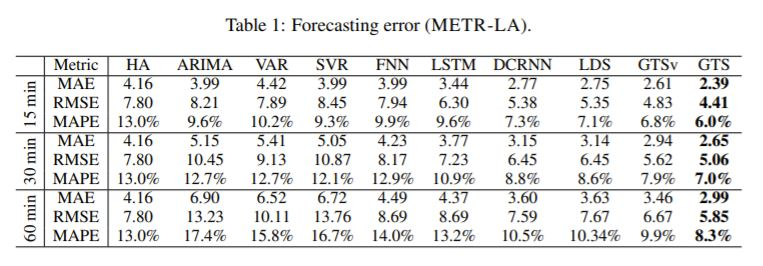


must define what results do we want to show